In [16]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import typing

In [17]:
# alphabet of death  useful for mapping the names into something more human readable
code_to_name = {
    'A-R_V-Y': 'Total Deaths',
    'ACC': 'Accidents',
    'A_B': 'Infectious and Parasitic Diseases',
    'C00-D48': 'Neoplasms',
    'D50-D89': 'Diseases of the Blood',
    'E': 'Endocrine, Nutritional and Metabolic Diseases',
    'F': 'Mental and Behavioural Disorders',
    'F10': 'Abuse of Alcohol',
    'G_H': 'Diseases of the Nervous System and the Sense Organs',
    'I': 'Diseases of the Circulatory System',
    'J': 'Diseases of the Respiratory System',
    'K': 'Diseases of the Digestive System',
    'L': 'Diseases of the Skin and Subcutaneous Tissue',
    'M': 'Diseases of the Musculoskeletal System and Connective Tissue',
    'N': 'Diseases of the Genitourinary System',
    'TOXICO': 'Abuse of Drugs',
    'U071': 'COVID-19',
    'V_Y85': 'Transport Accidents',
    'X60-X84_Y870': 'Intentional Self-Harm',
    'X85-Y09_Y871': 'Assault'
}


In [18]:
folder_path = 'DopData/uv/'

dat_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.dat')]

# List to store DataFrames
dataframes = []

for file_path in dat_files:
    # Extract country name from filename (modify this based on your actual filename structure)
    country_name = os.path.basename(file_path).replace('.dat', '').split('_')[-1]

    df = pd.read_csv(file_path, 
                     delim_whitespace=True, 
                     comment='#', 
                     header=None,
                     na_values=-1.000,
                     names=['YYYYMMDD', 'UVIEF', 'UVIEFerr', 'UVDEF', 'UVDEFerr', 'UVDEC', 'UVDECerr', 
                            'UVDVF', 'UVDVFerr', 'UVDVC', 'UVDVCerr', 'UVDDF', 'UVDDFerr', 'UVDDC', 'UVDDCerr', 
                            'CMF', 'ozone'])

    # Add country name as a new column
    df['Country'] = country_name

    dataframes.append(df)


In [152]:
#Reading in our Datasets
df_demographic = pd.read_csv("DopData/DemographicData.csv")
df_final1 = pd.read_csv("DopData/df_final1.csv", index_col=[0, 1])
cod_df = pd.read_csv("DopData/df_final2.csv", index_col=[0, 1])
df_final = pd.read_csv("DopData/df_final.csv", index_col=[0, 1])
df_health = pd.read_csv("DopData/df_health.csv")
df_poverty=pd.read_csv("DopData/ilc_mddd11_page_linear.csv",sep=",")
df_iem=pd.read_csv("DopData/ilc_mdes09_page_linear.csv",sep=",")
df_beds=pd.read_csv("DopData/tps00046_page_linear.csv",sep=",")
df_healthcare=pd.read_csv("DopData/hlth_sha11_hf_page_linear.csv",sep=",")

df_beds.drop(columns=['DATAFLOW', 'LAST UPDATE', 'freq', 'unit', 'facility', 'hlthcare', 'OBS_FLAG'],inplace=True)
df_poverty.drop(columns=["DATAFLOW","LAST UPDATE","freq","unit","age","sex","OBS_FLAG"],inplace=True)
df_iem.drop(columns=['DATAFLOW', 'LAST UPDATE', 'freq', 'unit', 'subjnmon', 'hhtyp','incgrp', 'OBS_FLAG'],inplace=True)
df_healthcare.drop(columns=['DATAFLOW', 'LAST UPDATE', 'freq', 'unit', 'icha11_hf', 'OBS_FLAG'],inplace=True)

display(df_healthcare)
#display(cod_df)
#display(df_final.head())
#display(df_health.head())

,geo,TIME_PERIOD,OBS_VALUE
0,AT,2013,10.29
1,AT,2014,10.37
2,AT,2015,10.37
3,AT,2016,10.35
4,AT,2017,10.38
...,...,...,...
347,UK,2015,9.90
348,UK,2016,9.87
349,UK,2017,9.81
350,UK,2018,9.90


In [184]:
df_beds["geo"].unique()

array(['AL', 'AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL',
       'ES', 'EU27_2020', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LI',
       'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO',
       'RS', 'SE', 'SI', 'SK', 'TR'], dtype=object)

In [21]:
df_healthcare.columns

Index(['geo', 'TIME_PERIOD', 'OBS_VALUE'], dtype='object')

In [122]:
# some datasets have a different column name for year 
df_health.rename(columns={'geo': 'country', 'TIME_PERIOD': 'year'}, inplace=True)
df_poverty.rename(columns={'geo': 'country', 'TIME_PERIOD': 'year',"OBS_VALUE":"Deprivation Rate"}, inplace=True)
df_iem.rename(columns={'geo': 'country', 'TIME_PERIOD': 'year',"OBS_VALUE":"Inabillity to make ends meet %"}, inplace=True)
df_beds.rename(columns={'geo': 'country', 'TIME_PERIOD': 'year',"OBS_VALUE":"Hospitalbeds per 100k pop"}, inplace=True)
df_healthcare.rename(columns={'geo': 'country', 'TIME_PERIOD': 'year',"OBS_VALUE":"Healthcare expend. % of GDP"}, inplace=True) 

In [123]:
# Here I deal with the multi index and year to prepare for the merge
cod_df_reset = cod_df.reset_index()
cod_df_reset = cod_df_reset.drop(index=0)
cod_df_reset.rename(columns={'causes of death': 'year', 'level_1': 'country'}, inplace=True)
cod_df_reset.rename(columns={'geo': 'country', 'TIME_PERIOD': 'year'}, inplace=True)
cod_df_reset['year'] = cod_df_reset['year'].astype(int)

# merging on country and year
data = pd.merge(df_demographic, cod_df_reset, on=['country', 'year'])
data=pd.merge(df_poverty,data, on=['country', 'year'])
data=pd.merge(df_iem,data, on=['country', 'year'])
data=pd.merge(df_beds,data, on=['country', 'year'])
data=pd.merge(df_healthcare,data, on=['country', 'year'])

# here NA columsn ar edropped but maybe we should replace them with the mean as flo mentioend
print(f"Number of NA rows {data.isna().any(axis=1).sum()}")
mean_values = data.mean()
df_filled = data.fillna(mean_values)

print(data[mask])
data = data.dropna()
 
display(data)
causes_of_death=cod_df_reset.columns.to_numpy()[2:]

Number of NA rows 2
    country  year  healthcare expend. % of GDPF  hospitalbeds per 100k pop  \
186      NO  2013                          8.87                     385.86   
188      NO  2015                         10.07                     376.19   

     inabillity to make ends meet %  deprivation rate  Unnamed: 0  \
186                             2.2               1.9         710   
188                             2.1               1.7         782   

     total population  Immigrants - emigrants  median age  ...      J      K  \
186         5079623.0                 38948.0         NaN  ...  97.15  28.22   
188         5188607.0                 26089.0         NaN  ...  97.53  29.10   

        L     M      N  TOXICO  U071  V_Y85  X60-X84_Y870  X85-Y09_Y871  
186  2.52  5.92  18.87    0.50   0.0   4.78         11.25          0.91  
188  2.33  7.12  18.18    0.64   0.0   3.49         11.71          0.43  

[2 rows x 32 columns]


C:\Users\DScie\AppData\Local\Temp\ipykernel_8860\4079145527.py:17: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_values = data.mean()


,country,year,healthcare expend. % of GDPF,hospitalbeds per 100k pop,inabillity to make ends meet %,deprivation rate,Unnamed: 0,total population,Immigrants - emigrants,median age,...,J,K,L,M,N,TOXICO,U071,V_Y85,X60-X84_Y870,X85-Y09_Y871
0,AT,2013,10.29,764.46,5.4,4.2,685,8479823.0,56122.0,42.6,...,50.55,37.08,0.76,3.27,18.44,2.25,0.00,5.88,15.35,0.44
1,AT,2014,10.37,758.39,5.6,4.0,721,8546356.0,73670.0,42.9,...,46.63,33.29,0.66,3.06,18.56,1.55,0.00,5.76,15.25,0.43
2,AT,2015,10.37,753.68,5.3,3.6,757,8642699.0,114237.0,43.0,...,54.50,33.93,0.66,3.20,20.93,1.41,0.00,5.85,14.45,0.57
3,AT,2016,10.35,742.14,4.3,3.0,793,8736668.0,65388.0,43.0,...,51.83,33.51,0.93,3.77,20.83,1.13,0.00,5.32,13.63,0.50
4,AT,2017,10.38,736.62,4.5,3.7,829,8797566.0,45039.0,43.0,...,62.32,33.36,0.92,3.82,21.60,1.06,0.00,5.18,13.84,0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,SK,2016,6.97,578.40,10.1,8.2,825,5430798.0,3885.0,39.4,...,78.64,67.58,5.21,1.86,23.47,0.00,0.00,7.17,7.48,0.74
237,SK,2017,6.76,582.05,8.1,7.0,861,5439232.0,3722.0,39.8,...,94.59,66.62,3.87,1.72,26.31,0.09,0.00,7.48,7.23,0.48
238,SK,2018,6.67,569.62,8.4,7.0,897,5446771.0,3955.0,40.2,...,86.96,71.65,5.25,1.96,25.90,0.06,0.00,7.15,7.94,0.58
239,SK,2019,6.92,576.11,9.4,7.9,933,5454147.0,3632.0,40.6,...,78.57,65.18,5.44,1.36,21.64,0.07,0.00,8.16,6.97,0.58


In [124]:
demographic_factors=list(data.columns[2:-20])
demographic_means=list(mean_values[1:-20])
print(demographic_factors)
print(demographic_means)

['healthcare expend. % of GDPF', 'hospitalbeds per 100k pop', 'inabillity to make ends meet %', 'deprivation rate', 'Unnamed: 0', 'total population', 'Immigrants - emigrants', 'median age', 'over 80', 'over 60']
[8.539377593360998, 495.4763070539419, 10.365145228215768, 7.833195020746889, 827.9585062240664, 28126030.15352697, 72820.26556016598, 41.7928870292887, 4.864016736401673, 24.628870292887026]


In [125]:
eu_data = data.groupby('year').mean(numeric_only=True).reset_index()
eu_data['country'] = 'EU'  # Add a new column for country and set it to 'EU' for the mean
data = pd.concat([data, eu_data], ignore_index=True)


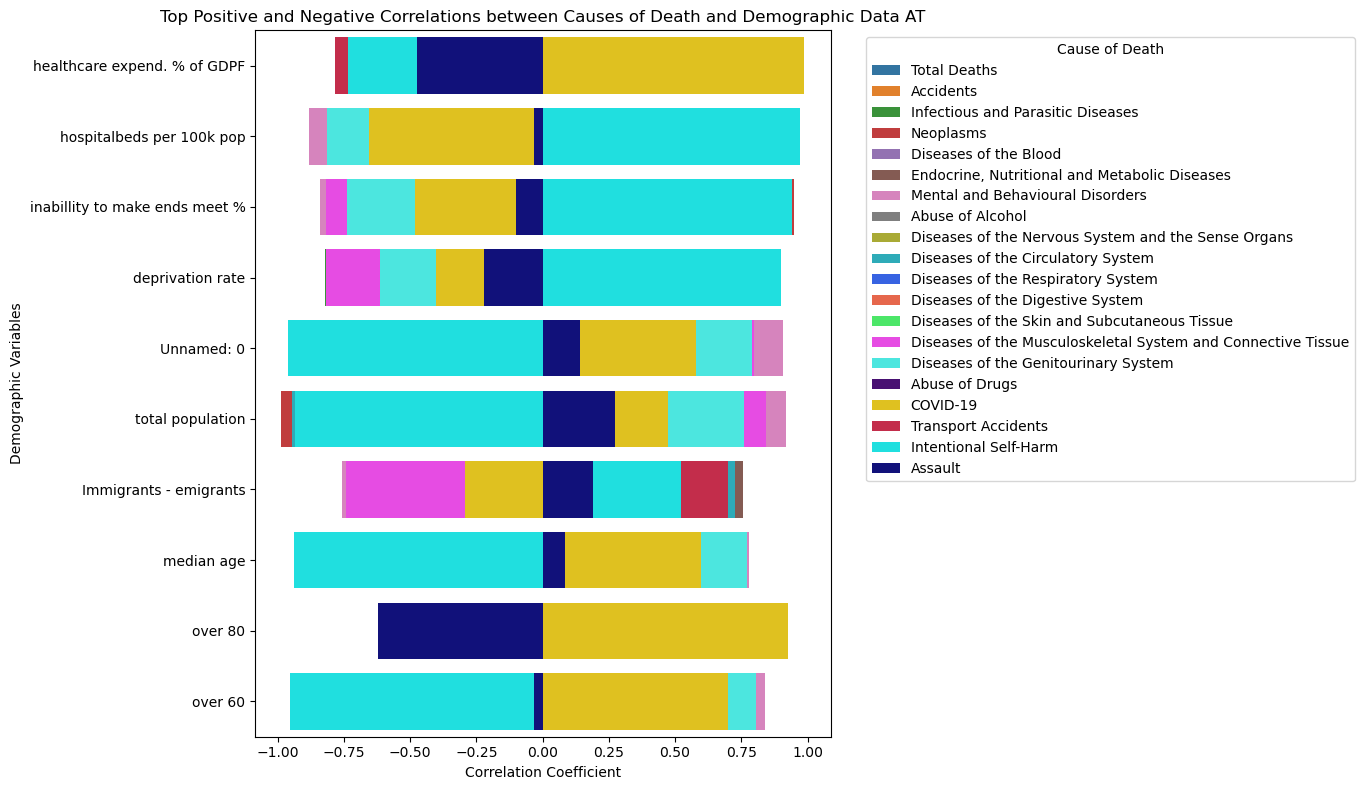

     CauseOfDeath             DemographicVariable  Correlation  AbsCorrelation
0    Total Deaths    healthcare expend. % of GDPF     0.345890        0.345890
1    Total Deaths       hospitalbeds per 100k pop     0.281139        0.281139
2    Total Deaths  inabillity to make ends meet %     0.423499        0.423499
3    Total Deaths                deprivation rate     0.471623        0.471623
4    Total Deaths                      Unnamed: 0    -0.344309        0.344309
..            ...                             ...          ...             ...
195       Assault                total population     0.273586        0.273586
196       Assault          Immigrants - emigrants     0.189789        0.189789
197       Assault                      median age     0.085303        0.085303
198       Assault                         over 80    -0.622425        0.622425
199       Assault                         over 60    -0.034652        0.034652

[200 rows x 4 columns]


In [126]:

# return corr matrix 
def get_country_corr(dataframe, country):
    country_data = dataframe[dataframe["country"] == country]
    return country_data.corr(numeric_only=True)

 

country_name = "AT"
corr = get_country_corr(data, country_name)

relevant_correlations = corr.loc[demographic_factors, causes_of_death]

flat_relevant_correlations = relevant_correlations.unstack().reset_index()
flat_relevant_correlations.columns = ['CauseOfDeath', 'DemographicVariable', 'Correlation']
flat_relevant_correlations.dropna(inplace=True)


flat_relevant_correlations['CauseOfDeath'] = flat_relevant_correlations['CauseOfDeath'].map(code_to_name)
sorted_relevant_correlations = flat_relevant_correlations.copy()
sorted_relevant_correlations['AbsCorrelation'] = sorted_relevant_correlations['Correlation'].abs()
# custom color codes so its clearer for the eye I asked GPT to generate those so if you add more columns just add some colors for them
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                  '#1a55FF', '#FF5733', '#33FF57', '#FF33FB', '#33FFF6',
                  '#4B0082', '#FFD700', '#DC143C', '#00FFFF', '#00008B']



plt.figure(figsize=(14,8))
sns.barplot(x='Correlation', y='DemographicVariable', data=sorted_relevant_correlations,
            hue='CauseOfDeath', dodge=False, palette=custom_palette)

plt.title('Top Positive and Negative Correlations between Causes of Death and Demographic Data ' + country_name)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Demographic Variables')
plt.legend(title='Cause of Death', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()
print(sorted_relevant_correlations)


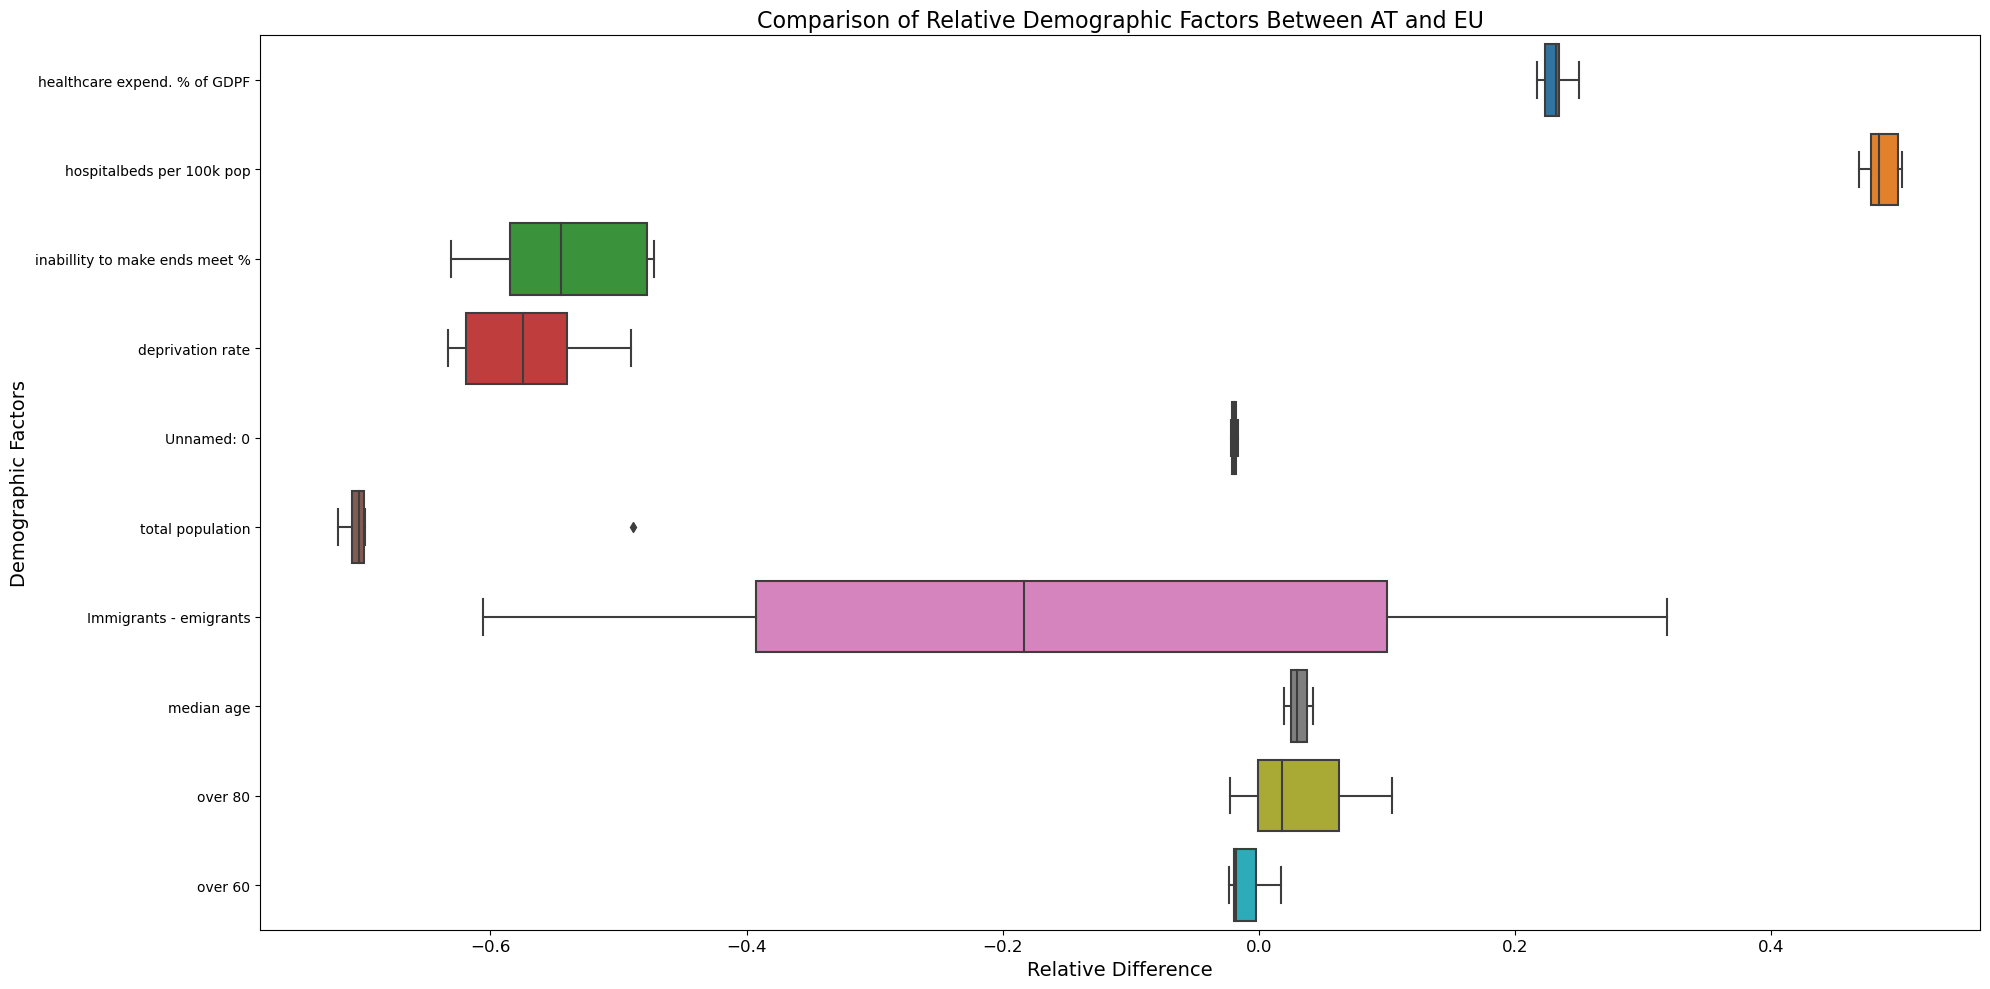

In [147]:

import seaborn as sns
def compare_countries(ca, cb, demographic_factors, data):
    data_ca = data[data["country"] == ca]
    data_cb = data[data["country"] == cb]

    common_years = set(data_ca["year"]).intersection(set(data_cb["year"]))

    data_ca = data_ca[data_ca["year"].isin(common_years)]
    data_cb = data_cb[data_cb["year"].isin(common_years)]

    cluster_stats = []

    for year in common_years:
        dem_country1 = data_ca[data_ca["year"] == year][demographic_factors]
        dem_country2 = data_cb[data_cb["year"] == year][demographic_factors]

        relative_diff = (dem_country1.values - dem_country2.values) / dem_country2.values
        cluster_stats.append(pd.Series(relative_diff.flatten(), index=demographic_factors))
    cluster_stats_df = pd.DataFrame(cluster_stats)

    # Plotting
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=cluster_stats_df, orient='h')
    plt.title(f"Comparison of Relative Demographic Factors Between {ca} and {cb}", fontsize=16)
    plt.xlabel("Relative Difference", fontsize=14)
    plt.ylabel("Demographic Factors", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=10)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cluster_stats_df


cluster_stats_df = compare_countries("AT", "EU", demographic_factors,data)


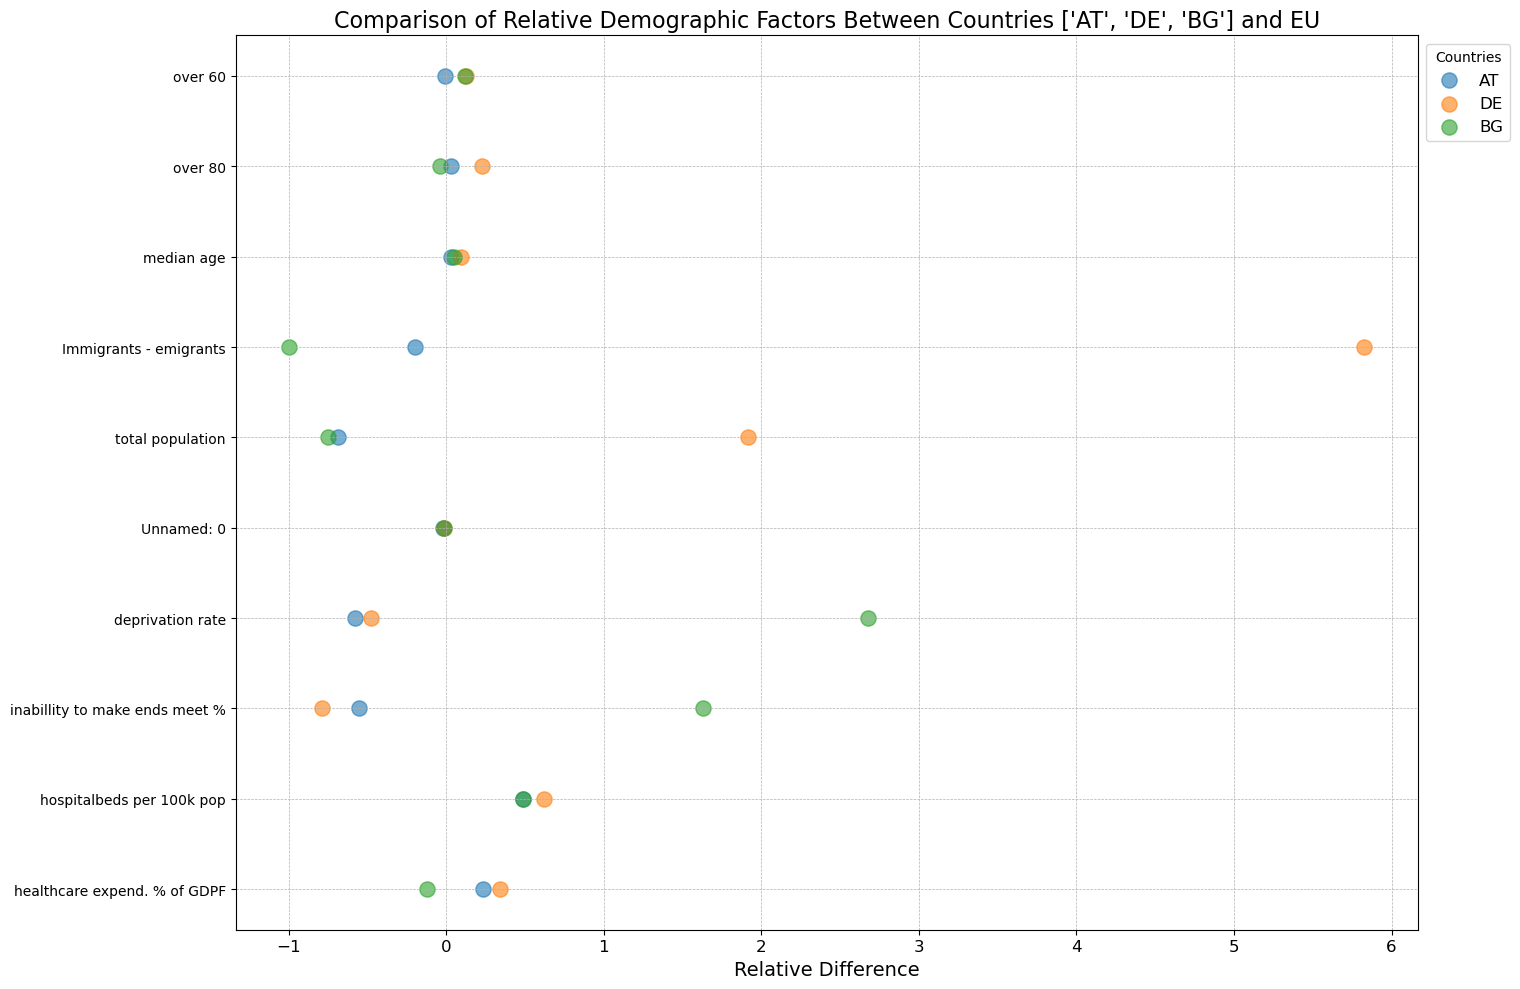

In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_countries_means(countries, cb, demographic_factors, data):
    common_years = set.intersection(*[set(data[data["country"] == c]["year"]) for c in countries + [cb]])

    cluster_stats = []

    for ca in countries:
        data_ca = data[(data["country"] == ca) & (data["year"].isin(common_years))]
        data_cb = data[(data["country"] == cb) & (data["year"].isin(common_years))]

        dem_country1 = data_ca[demographic_factors].mean()
        dem_country2 = data_cb[demographic_factors].mean()

        relative_diff = (dem_country1.values - dem_country2.values) / dem_country2.values
        cluster_stats.append(pd.Series(relative_diff.flatten(), index=demographic_factors))

    cluster_stats_df = pd.DataFrame(cluster_stats, index=countries)

    # Plotting
    plt.figure(figsize=(18, 10))
    colors = plt.cm.tab10.colors   

    for i, country in enumerate(countries):
        y = range(len(demographic_factors))
        plt.scatter(cluster_stats_df.loc[country], y, label=country, s=120, alpha=0.6, color=colors[i % len(colors)])

    plt.title(f"Comparison of Relative Demographic Factors Between Countries {countries} and {cb}", fontsize=16)
    plt.xlabel("Relative Difference", fontsize=14)
    plt.yticks(y, demographic_factors, fontsize=10)
    plt.xticks(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(title="Countries", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout(rect=[0,0,0.85,1])  
    plt.show()

    return cluster_stats_df

# example  
# countries_list = ["AT", "DE", "FR"]   
cluster_stats_df = compare_countries_means(Clusters[0], "EU", demographic_factors, data)


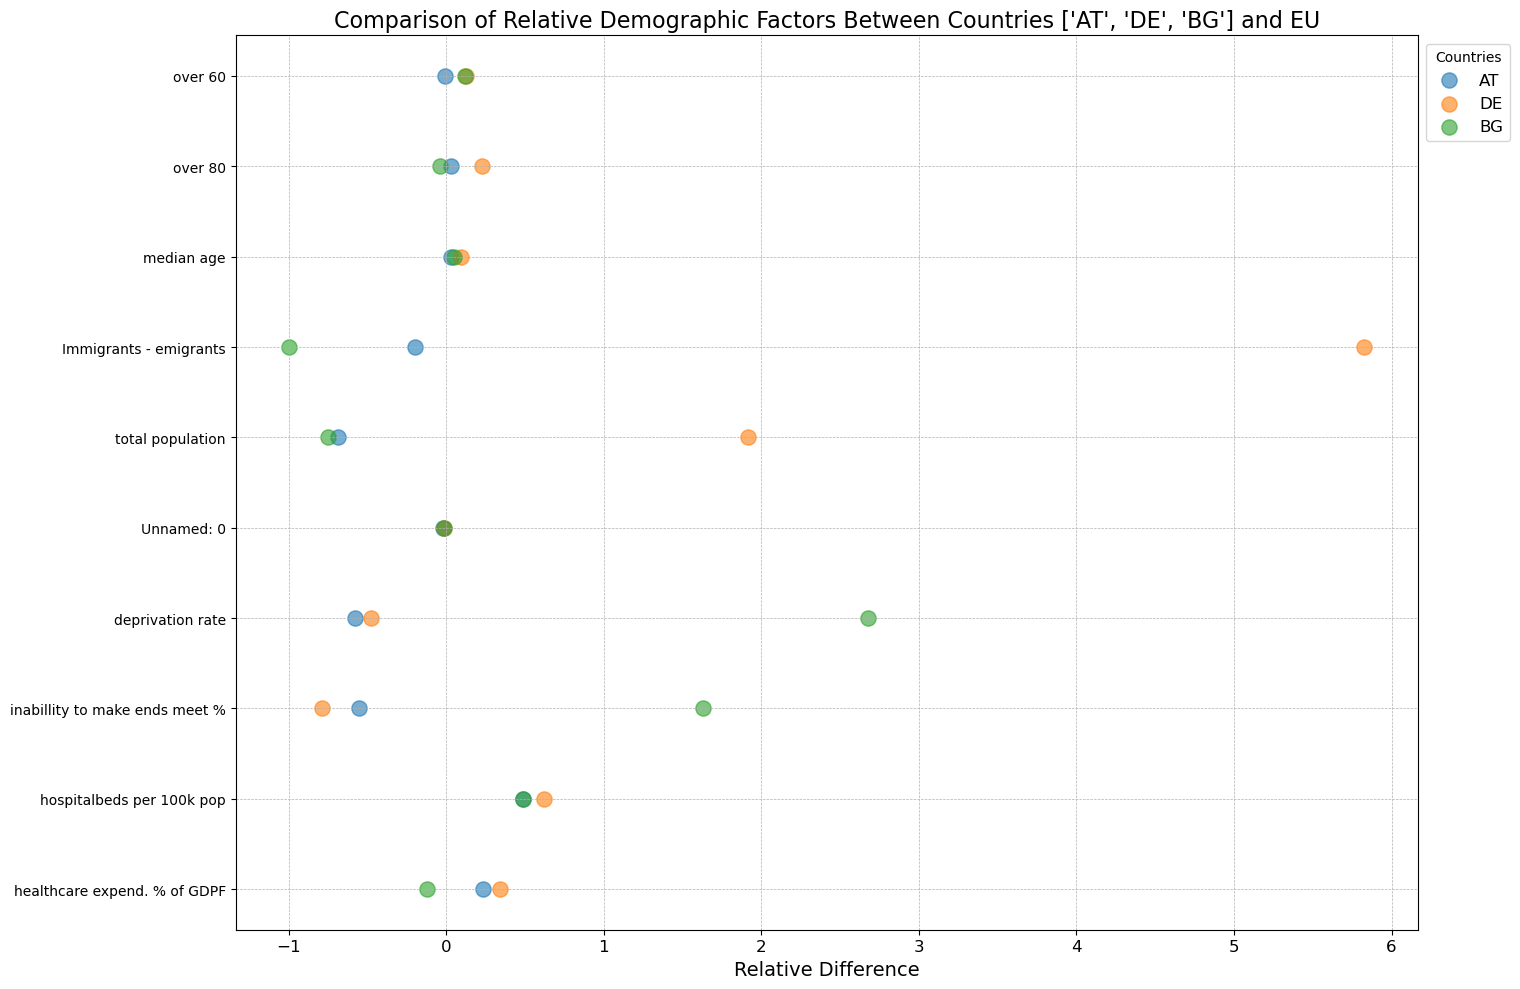

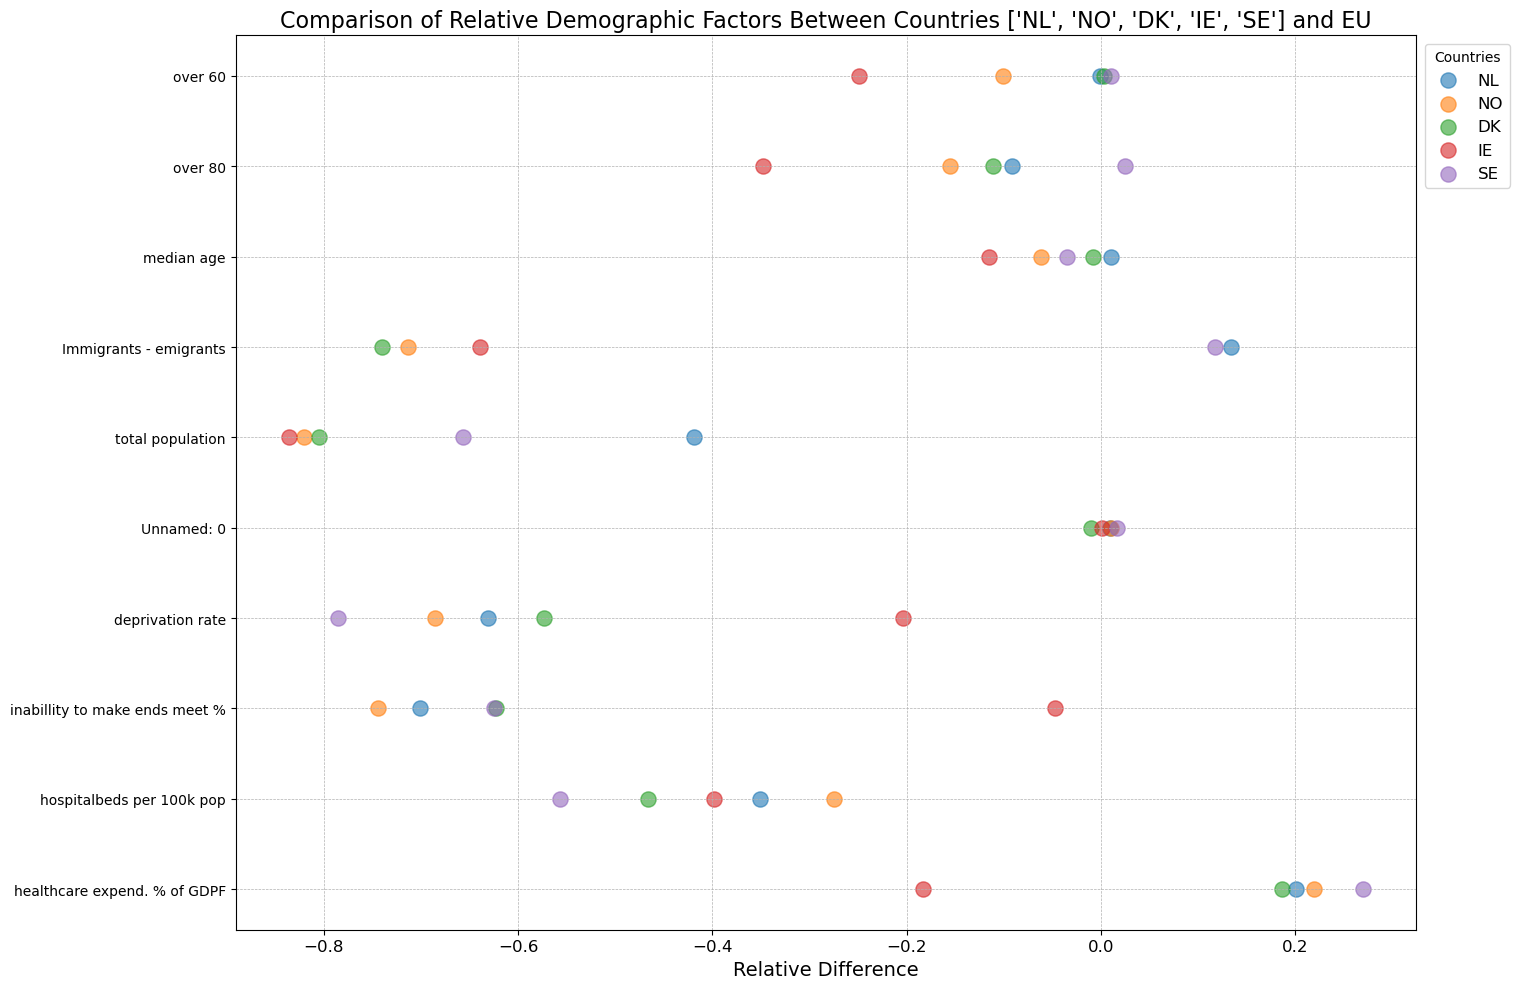

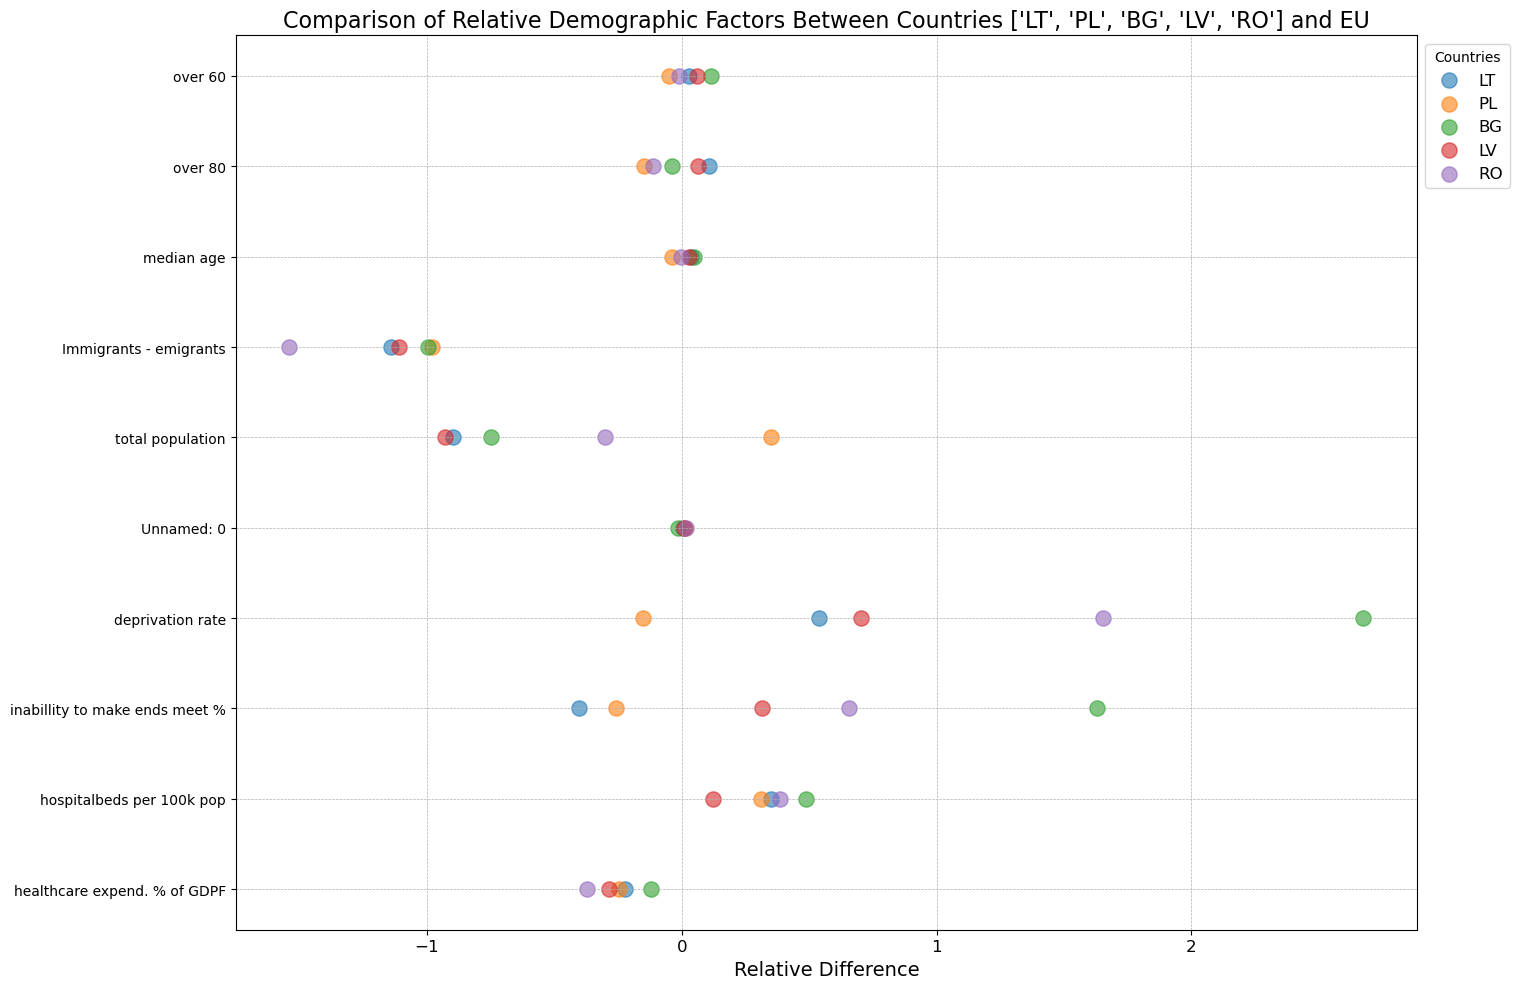

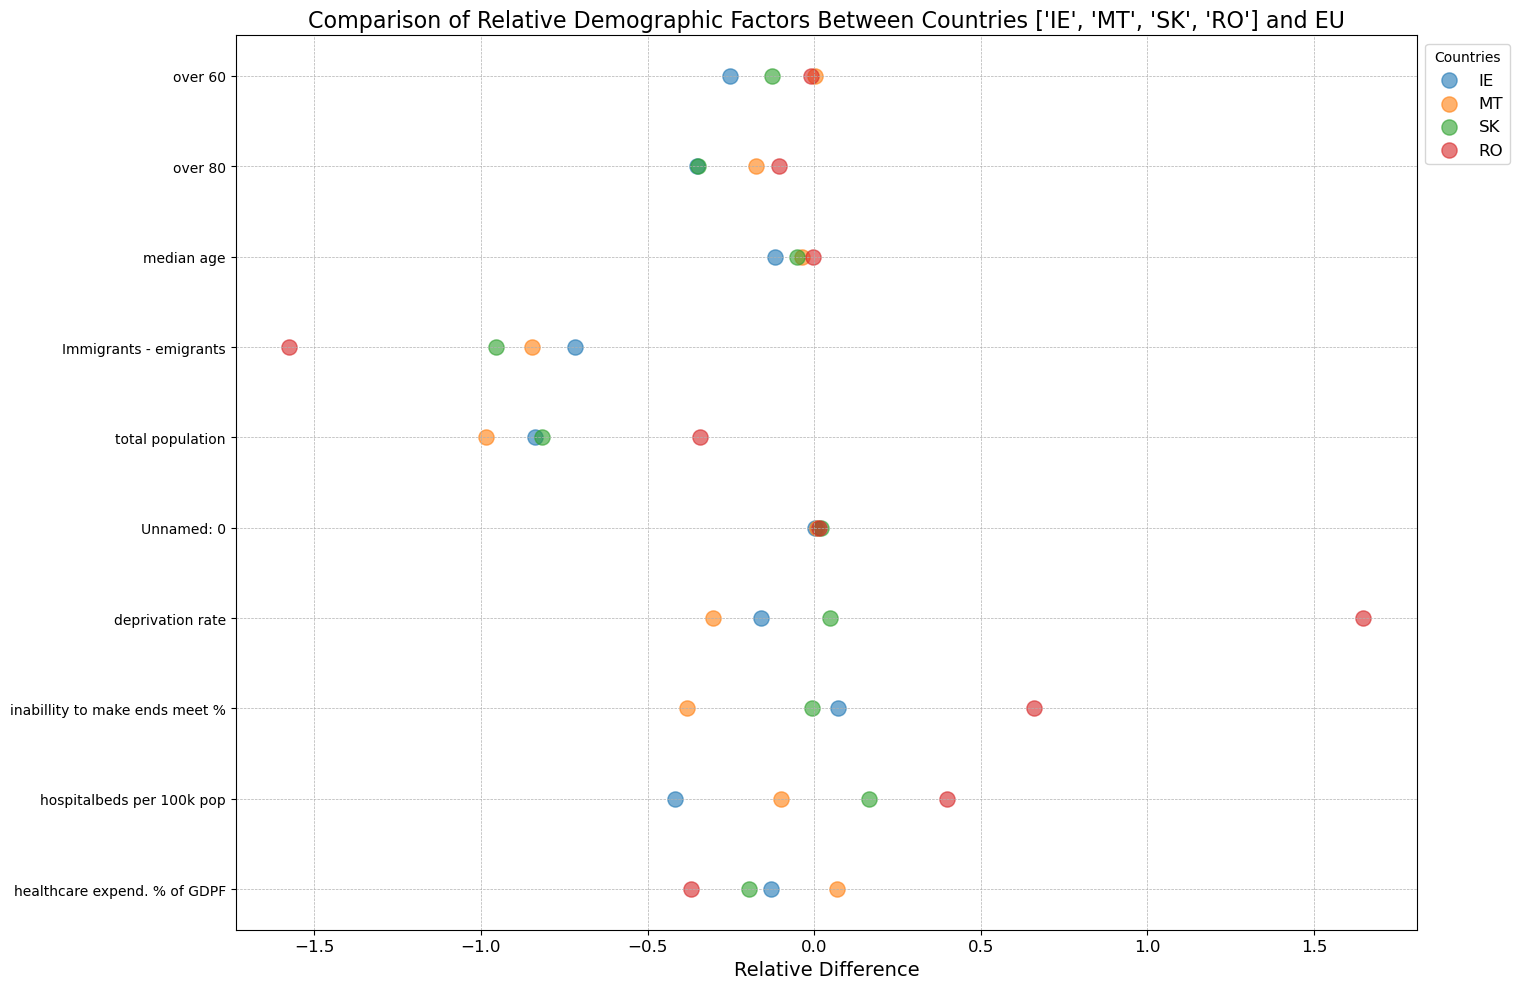

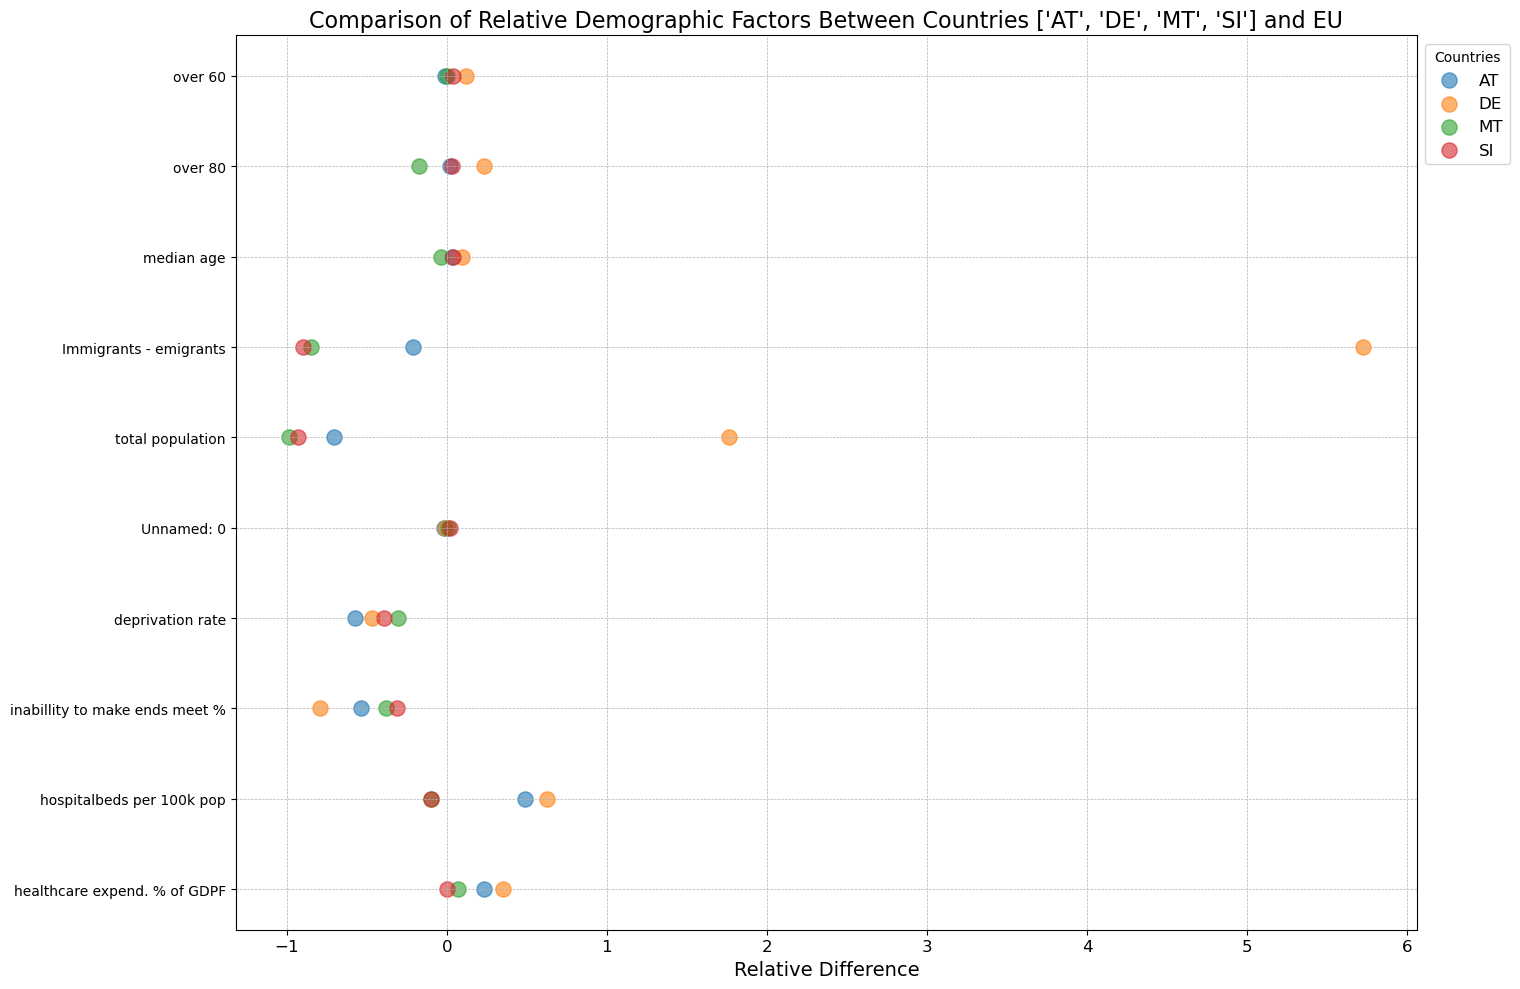

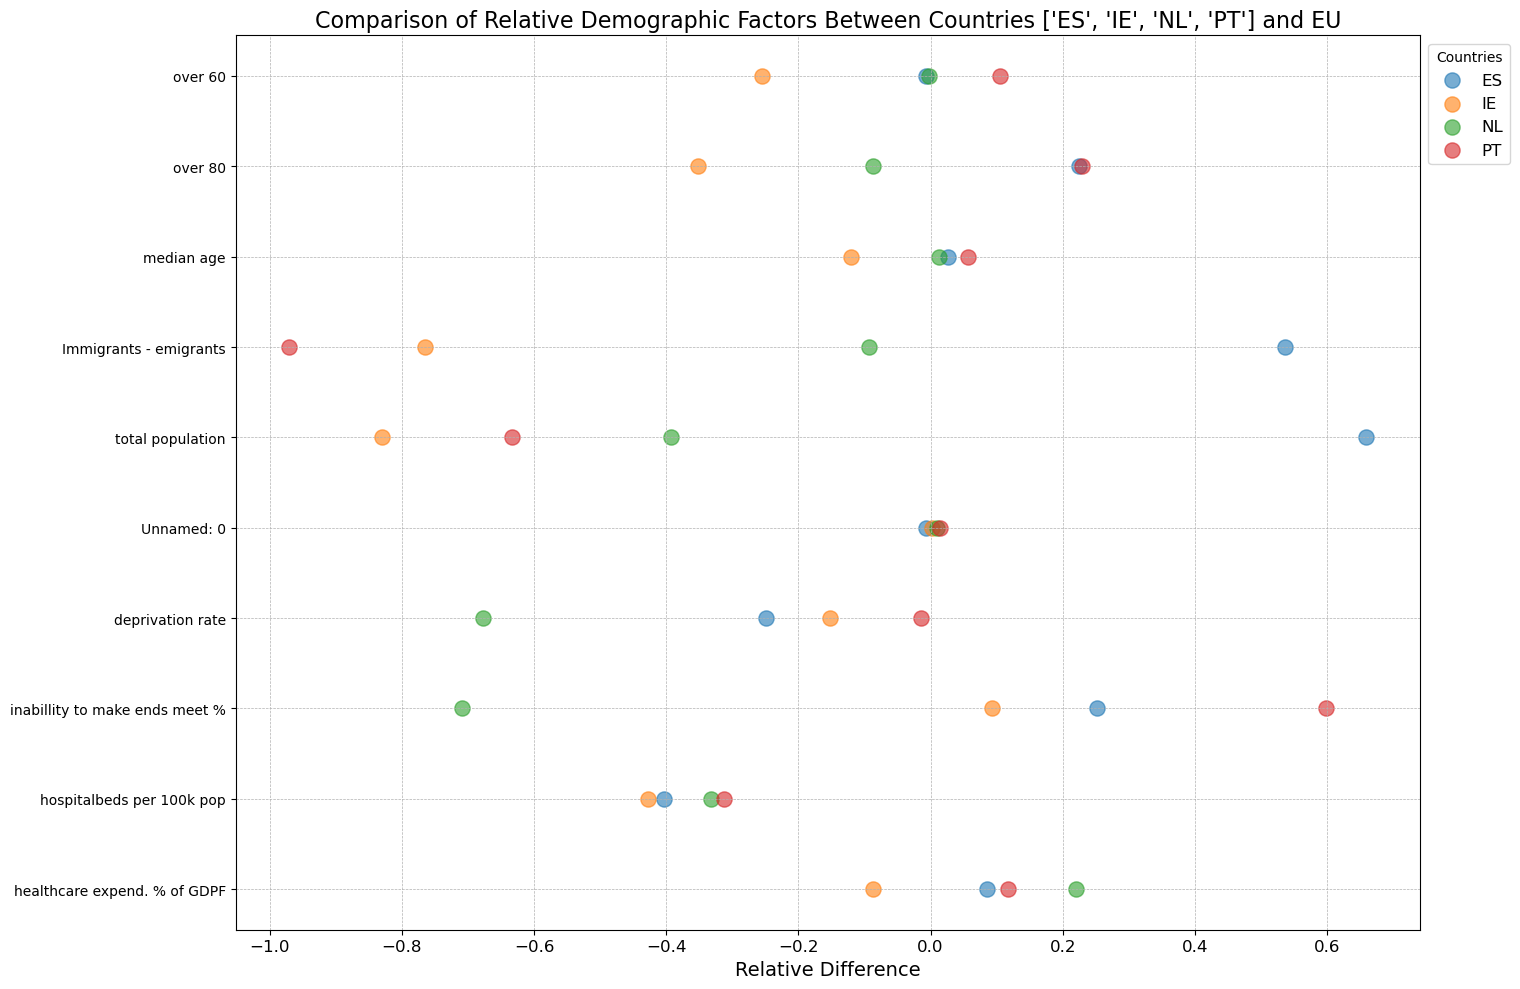

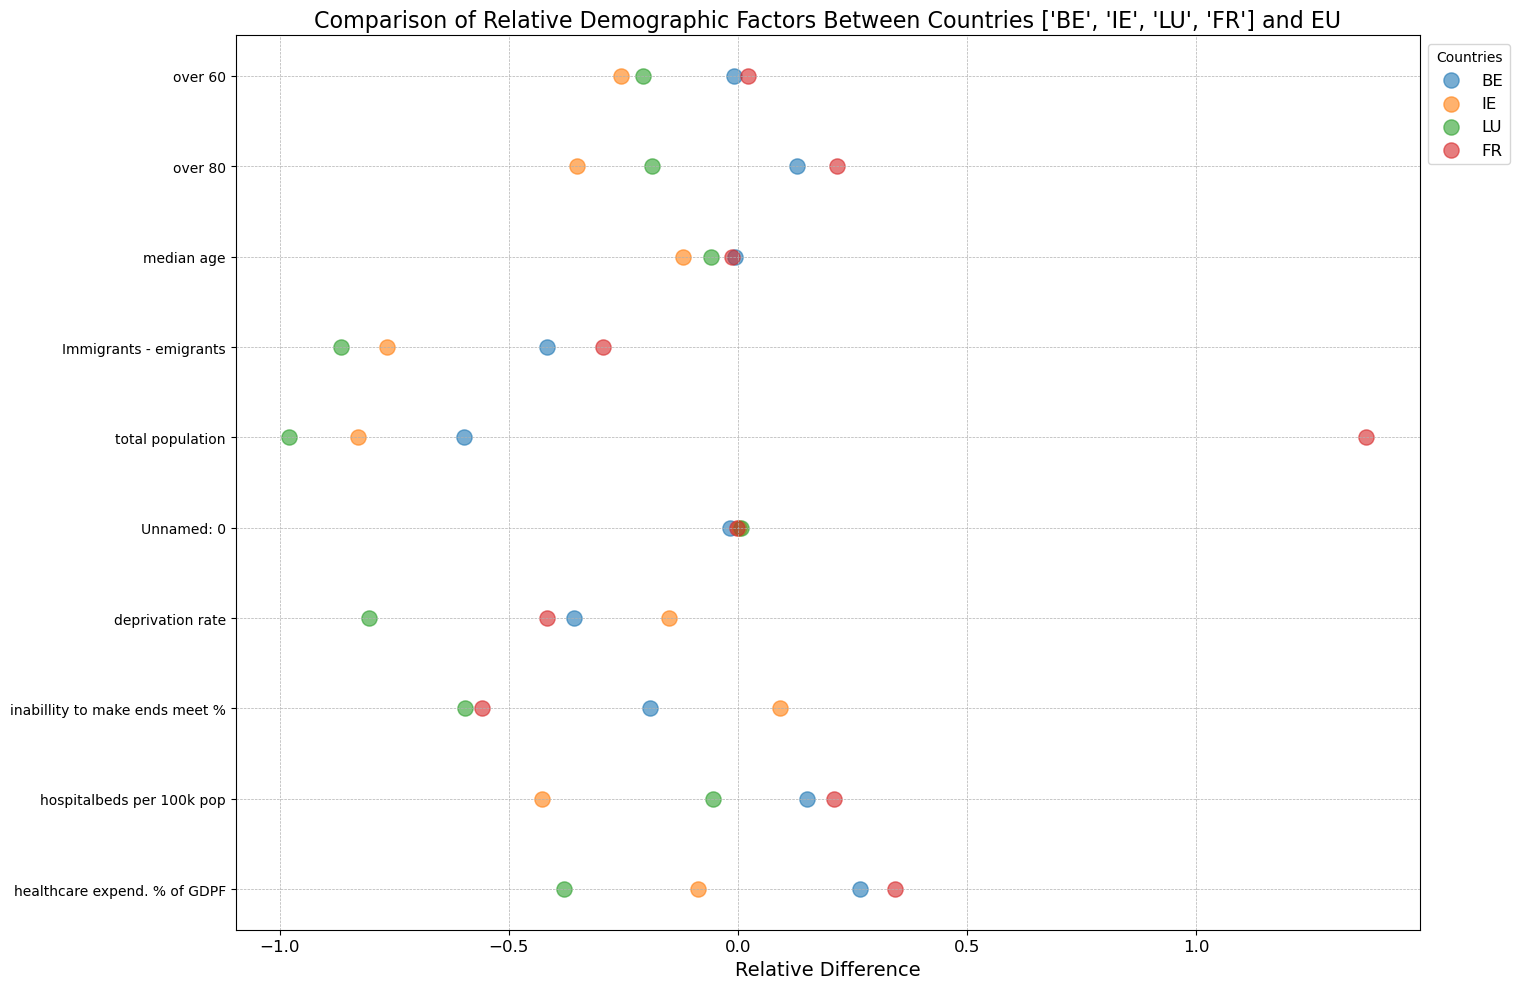

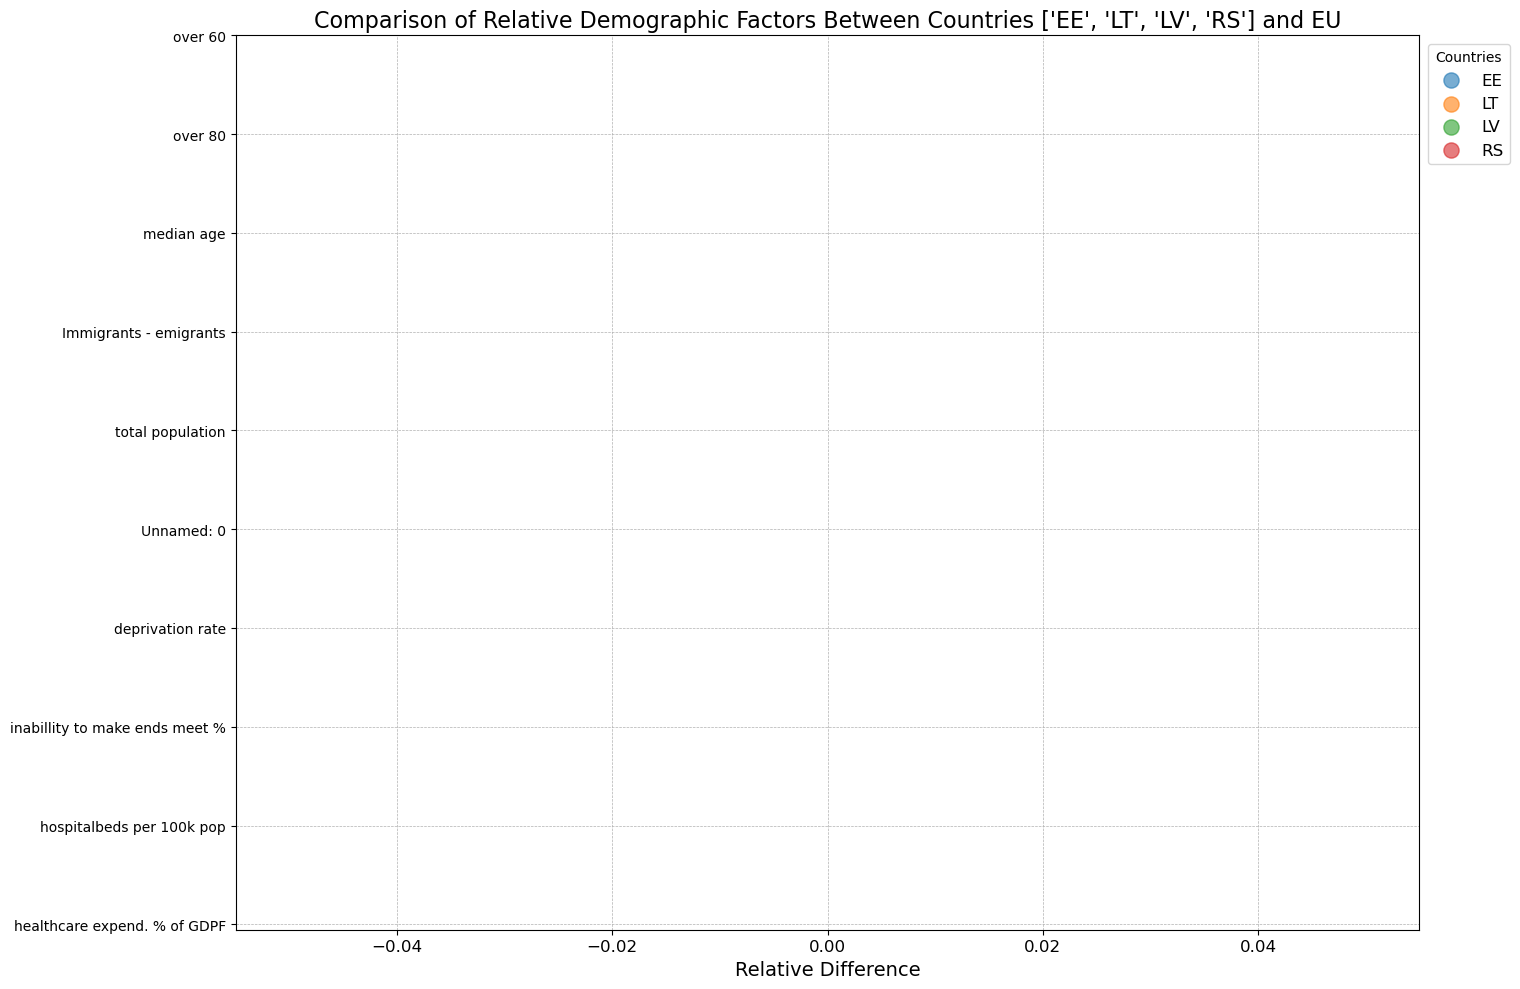

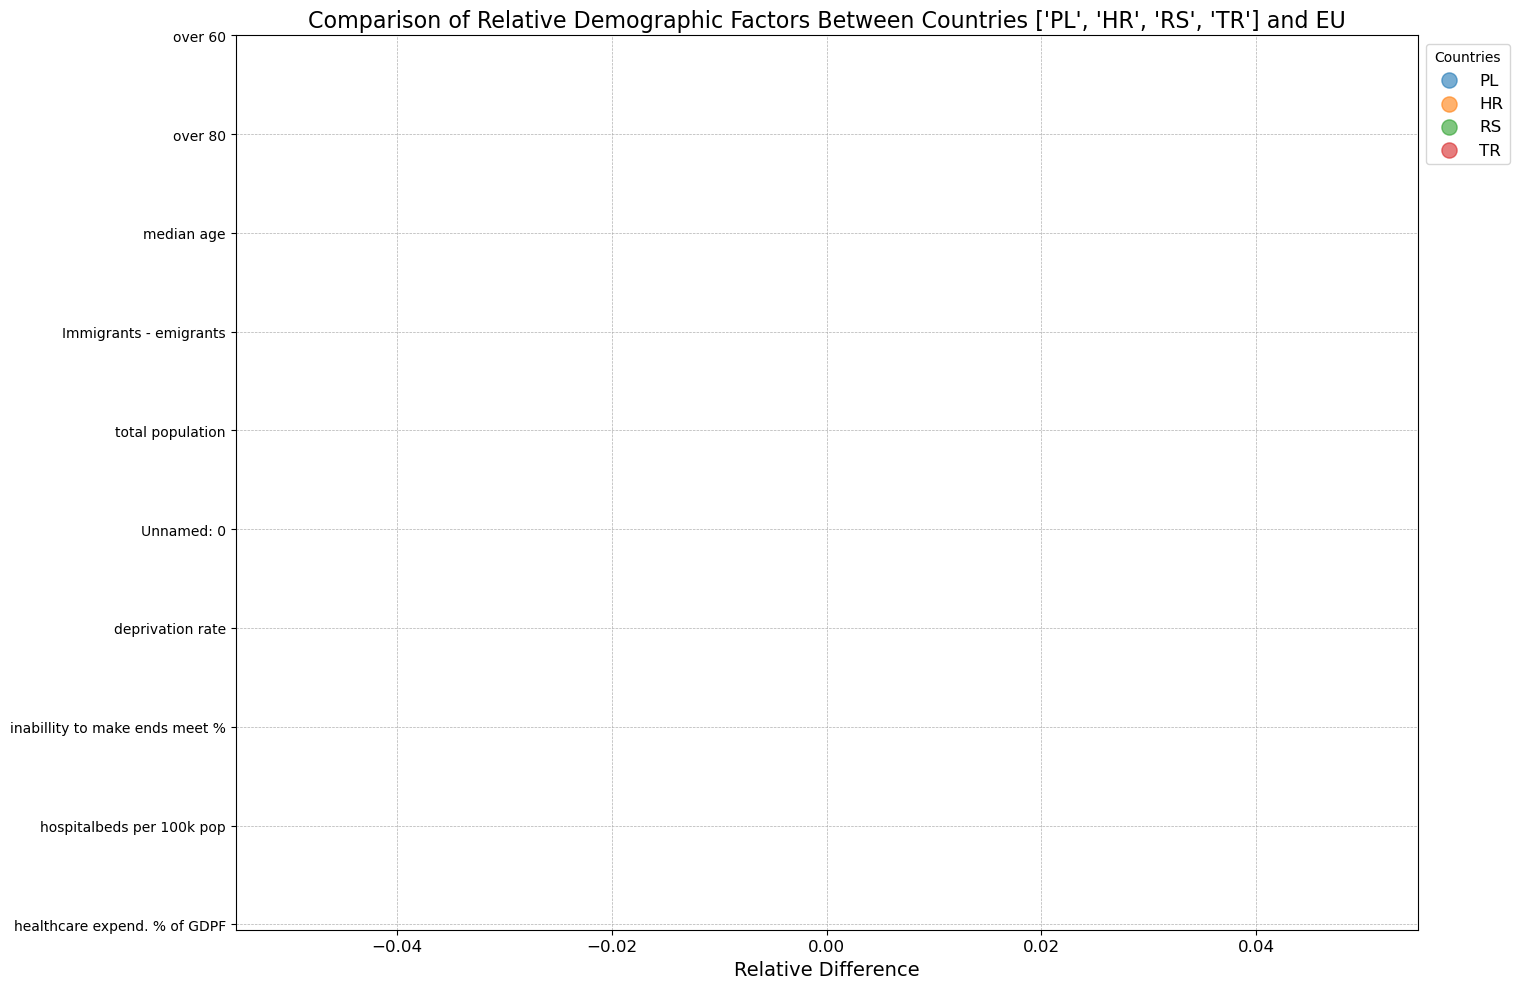

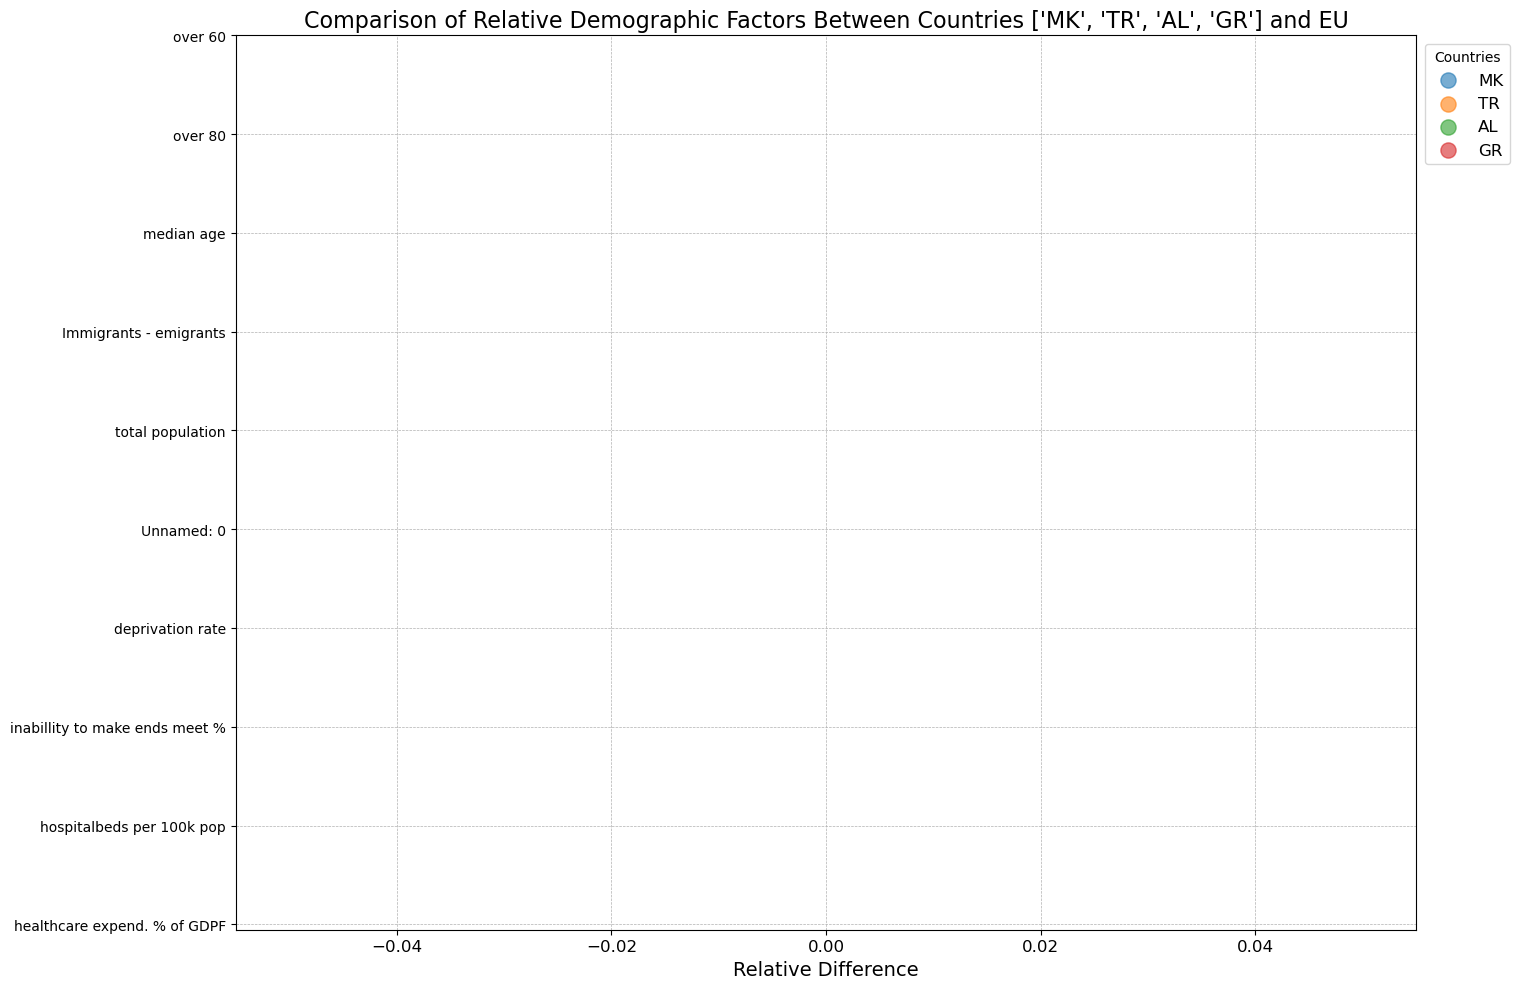

In [187]:
import itertools
 
Clusters = [
    ["AT","DE","BG"],
    ["NL", "NO", "DK", "IE", "SE"],
    ["LT", "PL", "BG", "LV", "RO"],
    ["IE", "MT",  "SK", "RO"],
    ["AT", "DE", "MT", "SI"],
    ["ES", "IE", "NL", "PT"],
    ["BE", "IE", "LU", "FR"],
    ["EE", "LT", "LV", "RS"],
    ["PL", "HR", "RS", "TR"],
    ["MK", "TR", "AL", "GR"]
]

 
for cluster in Clusters:
    luster_stats_df = compare_countries_means(cluster, "EU", demographic_factors,data)
 
